In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [2]:
# Step 1: Define paths
train_path = r"C:\Users\RISHI PANDE\Documents\Prediction\Train"
test_path = r"C:\Users\RISHI PANDE\Documents\Prediction\Test"

In [3]:
# Step 2: Data Preprocessing
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (248, 248))
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    return image, hsv_image

In [4]:
def extract_color_features(image):
    avg_red = np.mean(image[:, :, 2])
    avg_green = np.mean(image[:, :, 1])
    avg_blue = np.mean(image[:, :, 0])
    mean_rgb = (avg_red + avg_green + avg_blue) / 3
    return avg_red, avg_green, avg_blue, mean_rgb

In [5]:
def load_dataset(folder_path):
    images = []
    labels = []
    for category in os.listdir(folder_path):
        category_path = os.path.join(folder_path, category)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            image, hsv_image = preprocess_image(image_path)
            avg_red, avg_green, avg_blue, mean_rgb = extract_color_features(image)
            hsv_mean = np.mean(hsv_image)
            images.append([image, avg_red, avg_green, avg_blue, mean_rgb, hsv_mean, hsv_image, category])
            labels.append(category)
    return images, labels

In [6]:

train_images, train_labels = load_dataset(train_path)
test_images, test_labels = load_dataset(test_path)

In [7]:
# Convert to DataFrame
columns = ['Image', 'Avg Red Pixel', 'Avg Green Pixel', 'Avg Blue Pixel', 'Mean RGB Value', 'Mean HSV Value', 'HSV Image', 'Label']
train_df = pd.DataFrame(train_images, columns=columns)
test_df = pd.DataFrame(test_images, columns=columns)

In [9]:
# Extract only image data for augmentation
train_image_data = np.array([item[0] for item in train_images])

In [10]:
# Step 3: Data Augmentation
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
datagen.fit(train_image_data)

In [11]:
# Step 4: Build the CNN Model with Transfer Learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(248, 248, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_df['Label'].unique()), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
# Prepare labels for training
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
train_labels_categorical = to_categorical(train_labels_encoded)

test_labels_encoded = label_encoder.transform(test_labels)
test_labels_categorical = to_categorical(test_labels_encoded)

In [13]:
# Step 5: Train the Model
history = model.fit(datagen.flow(train_image_data, train_labels_categorical, batch_size=32), epochs=25, validation_data=(np.array([item[0] for item in test_images]), test_labels_categorical))

Epoch 1/25


c:\Users\RISHI PANDE\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.5238 - loss: 2.6327 - val_accuracy: 0.6800 - val_loss: 1.8273
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.7580 - loss: 0.8999 - val_accuracy: 0.8400 - val_loss: 0.3228
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.8589 - loss: 0.4525 - val_accuracy: 0.8400 - val_loss: 0.2856
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.8784 - loss: 0.2842 - val_accuracy: 0.9200 - val_loss: 0.1613
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9669 - loss: 0.1405 - val_accuracy: 0.9600 - val_loss: 0.1223
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9884 - loss: 0.0776 - val_accuracy: 0.9800 - val_loss: 0.0564
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9602 - loss: 0.0963 - val_accuracy: 0.7000 - val_loss: 0.7694
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8548 - loss: 0.4695 - val_accuracy: 0.8800 - val_loss: 0.5187
Epo

In [21]:
# Step 6: Evaluate the Model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [24]:
print("Training Accuracy: ", acc[-1])
print("Validation Accuracy: ", val_acc[-1])

Training Accuracy:  0.9937694668769836
Validation Accuracy:  1.0


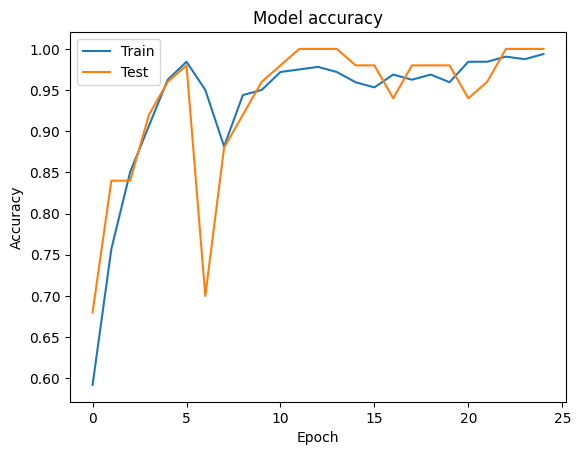

In [22]:
plt.plot(acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [25]:
# Confusion Matrix
pred_labels = model.predict(np.array([item[0] for item in test_images]))
pred_labels_classes = np.argmax(pred_labels, axis=1)
conf_matrix = confusion_matrix(test_labels_encoded, pred_labels_classes)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

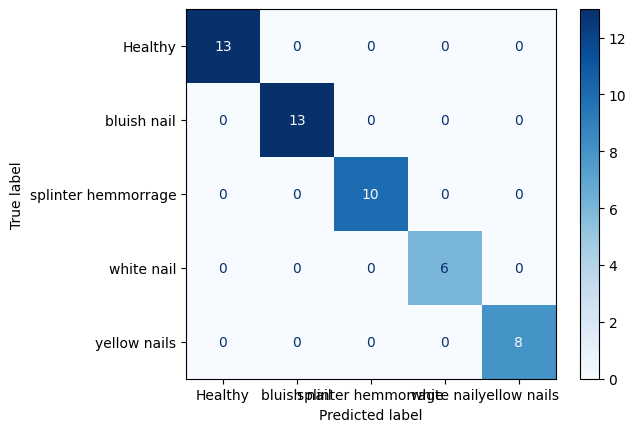

In [30]:
# Display Confusion Matrix as Image
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [35]:
# Save the Model
model.save(os.path.join(r"C:\Users\RISHI PANDE\Documents\Prediction", "Train_Model.keras"))

In [36]:
# Save CSV
train_df.to_csv(os.path.join(r"C:\Users\RISHI PANDE\Documents\Prediction", "train_data.csv"), index=False)
test_df.to_csv(os.path.join(r"C:\Users\RISHI PANDE\Documents\Prediction", "test_data.csv"), index=False)

In [37]:
# Display few rows from CSV
print(train_df.head())
print(test_df.head())

                                               Image  Avg Red Pixel  \
0  [[[237, 239, 235], [237, 238, 234], [236, 237,...     176.218327   
1  [[[225, 226, 225], [223, 225, 223], [221, 223,...     149.849473   
2  [[[55, 71, 137], [55, 71, 137], [56, 72, 138],...     158.888154   
3  [[[40, 55, 112], [40, 55, 112], [39, 54, 111],...     149.297948   
4  [[[124, 139, 187], [124, 139, 187], [124, 139,...     152.064289   

   Avg Green Pixel  Avg Blue Pixel  Mean RGB Value  Mean HSV Value  \
0       137.372236      133.816809      149.135791       95.748634   
1       125.608887      112.120659      129.193006       80.107733   
2       112.623146      104.251171      125.254157       95.938145   
3        97.341360       88.739659      111.792989       99.889698   
4        99.883731       90.122122      114.023381      101.502591   

                                           HSV Image        Label  
0  [[[75, 4, 239], [83, 4, 238], [80, 3, 237], [7...  bluish nail  
1  [[[60, 1, 226

In [107]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [108]:
# Define the path to the test folder
test_folder = r"C:\Users\RISHI PANDE\Documents\Prediction\Test"


In [109]:
# Step 1: Preprocess all test images
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (248, 248))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = image / 255.0  # Normalize the image
    return image

# Collect all test image paths
test_images = []
for root, dirs, files in os.walk(test_folder):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            image_path = os.path.join(root, file)
            test_images.append(image_path)

# Preprocess all test images
test_images_preprocessed = np.array([preprocess_image(image_path) for image_path in test_images])

# Step 2: Make predictions for all test images
test_pred_probabilities = model.predict(test_images_preprocessed)
test_pred_labels = np.argmax(test_pred_probabilities, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


In [8]:
# Get true labels for evaluation
label_map = {
    'bluish nail': 0,
    'Healthy': 1,
    'splinter hemmorrage': 2,
    'white nail': 3,
    'yellow nails': 4
}
test_true_labels = np.array([label_map[os.path.basename(os.path.dirname(image_path))] for image_path in test_images])


NameError: name 'test_images' is not defined

In [9]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Define paths to the dataset folders
train_folder = r"C:\Users\RISHI PANDE\Documents\Prediction\Train"

# Step 1: Load and preprocess training images
def load_and_preprocess_data(folder_path):
    images = []
    labels = []

    # Iterate through each folder (class) in the dataset
    for i, folder in enumerate(sorted(os.listdir(folder_path))):
        label = folder  # Use folder name as label

        # Iterate through each image in the current folder
        for file in os.listdir(os.path.join(folder_path, folder)):
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                image_path = os.path.join(folder_path, folder, file)
                image = cv2.imread(image_path)
                image = cv2.resize(image, (248, 248))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
                image = image / 255.0  # Normalize the image
                images.append(image)
                labels.append(label)

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Encode labels
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    return images, labels_encoded, label_encoder

# Load and preprocess training data
train_images, train_labels, label_encoder = load_and_preprocess_data(train_folder)

# Shuffle the dataset
shuffle_indices = np.random.permutation(len(train_images))
train_images = train_images[shuffle_indices]
train_labels = train_labels[shuffle_indices]

# Step 2: Define the CNN model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(248, 248, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 3: Train the model
history = model.fit(train_images, train_labels, epochs=20, batch_size=32, validation_split=0.2)

# Step 4: Evaluate the model
# (You can use the code provided earlier to evaluate the model on the test set)


c:\Users\RISHI PANDE\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.2785 - loss: 3.7866 - val_accuracy: 0.6615 - val_loss: 1.0787
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5658 - loss: 1.2313 - val_accuracy: 0.7077 - val_loss: 0.8358
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5984 - loss: 1.0419 - val_accuracy: 0.6923 - val_loss: 0.7971
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6821 - loss: 0.8757 - val_accuracy: 0.7538 - val_loss: 0.7416
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7257 - loss: 0.8716 - val_accuracy: 0.6308 - val_loss: 1.0206
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 924ms/step - accuracy: 0.6555 - loss: 0.8351 - val_accuracy: 0.8308 - val_loss: 0.6553
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7772 - loss: 0.6462 - val_accuracy: 0.7846 - val_loss: 0.6065
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7822 - loss: 0.6145 - val_accuracy: 0.7385 - val_loss: 0.5911
Epoch 9/20
8

In [10]:

# Step 6: Evaluate the Model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [11]:
print("Training Accuracy: ", acc[-1])
print("Validation Accuracy: ", val_acc[-1])

Training Accuracy:  0.94140625
Validation Accuracy:  0.800000011920929


In [12]:
# Step 3: Predict using the model
pred_labels = model.predict(test_images_preprocessed)
pred_labels_classes = np.argmax(pred_labels, axis=1)

# Step 4: Evaluate using confusion matrix
conf_matrix = confusion_matrix(test_labels_encoded, pred_labels_classes, labels=np.arange(len(label_encoder.classes_)))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')

NameError: name 'test_images_preprocessed' is not defined

In [2]:
from tensorflow.keras.models import save_model

# Define the path to save the model
model_save_path = r"C:\Users\RISHI PANDE\Documents\Prediction\Train_Model.h5"

# Save the model
model.save(model_save_path)

print(f"Model saved successfully at: {model_save_path}")

Model saved successfully at: C:\Users\RISHI PANDE\Documents\Prediction\Train_Model.h5


In [3]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the saved model
model_path = r"C:\Users\RISHI PANDE\Documents\Prediction\Train_Model.h5"
model = load_model(model_path)

# Function to preprocess a single image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (248, 248))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = image.astype(np.float32) / 255.0  # Normalize to [0, 1]
    return image

# Path to the test image
test_image_path = r"C:\Users\RISHI PANDE\Documents\Prediction\Test\yellow nails\3.PNG"

# Preprocess the test image
test_image = preprocess_image(test_image_path)

# Reshape the image to match model input shape (add batch dimension)
test_image_input = np.expand_dims(test_image, axis=0)

# Predict using the model
predictions = model.predict(test_image_input)

# Get the predicted class probabilities and labels
predicted_class_prob = np.max(predictions)
predicted_class_index = np.argmax(predictions)
predicted_class = label_encoder.classes_[predicted_class_index]

# Display results
print(f"Original Image:")
original_image = cv2.imread(test_image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display
plt.imshow(original_image)
plt.axis('off')
plt.show()

print(f"Probability of ({predicted_class}) is: {predicted_class_prob:.6f}")
print(f"Final Diagnosis result: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


NameError: name 'label_encoder' is not defined